style classifier - some code inspired by https://github.com/nicku-a/Weather_Classification/blob/main/WeatherClassifier.ipynb

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union
import pandas as pd

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score
from src.denoise_utils import denoise, denoise_particles
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style
from src.steps import Steps

import torch
import torch.nn as nn
import torch.nn.functional as F
# import autograd.numpy as anp
from collections import deque

# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"

# tf32 faster computation with Ampere
torch.backends.cuda.matmul.allow_tf32 = True
device = "cuda"
dtype=torch.float32
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
# pipe = pipe.to(device)
pipe.safety_checker = None
pipe.enable_attention_slicing() # NOTE: 10% slower inference, but big memory savings
# pipe.enable_sequential_cpu_offload() # NOTE: May slow down inference a lot
pipe.enable_vae_slicing() # TODO: Try to give batches to VAE
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

# Traced UNet? https://huggingface.co/docs/diffusers/optimization/fp16

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# Settings
prompt = "portrait of a woman by Paul Cezanne"
# prompt =  ["anime | strong warrior princess| centered| key visual| intricate| highly detailed| breathtaking beauty| precise lineart| vibrant| comprehensive cinematic| Carne Griffiths| Conrad Roset"]
numparticles = 10
single_initial_latent = False

if single_initial_latent:
    num_init_latents = 1
    addpart_level = 0 # Add particles in lvl 0
else:
    num_init_latents = numparticles
    addpart_level = None # Don't add any more particles
batch_size = min(50, numparticles)

config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "num_init_latents": num_init_latents, # 1 or numparticles
    "batch_size": batch_size,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

# Seeds
seed=0
generator = torch.Generator("cuda").manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompt, config, generator=generator, device="cuda", init_strat="normal")
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

NameError: name 'pipe' is not defined

In [11]:
text_embeddings.shape

torch.Size([101, 77, 1024])

In [17]:
steps = Steps(init_method="score") #repulsive_no_noise
# steps.add_all(method,2)
# steps.add_list(list(range(10,20)),method,[10]*10)
# steps.add_list([0,1,2,3],method,[10,10,10,10])
# steps.add_list([5],method,[2])
particles = denoise_particles(
    config, generator, num_particles=10, steps=steps.steps,
    correction_step_type="auto",
    addpart_level=None,
)

  0%|          | 0/20 [00:00<?, ?it/s]

56.526512145996094
0


 10%|█         | 2/20 [00:02<00:19,  1.11s/it]

28.643701553344727
1


 15%|█▌        | 3/20 [00:03<00:16,  1.03it/s]

15.16569709777832
2


 20%|██        | 4/20 [00:03<00:14,  1.10it/s]

8.372246742248535
3


 25%|██▌       | 5/20 [00:04<00:13,  1.15it/s]

4.808472156524658
4


 30%|███       | 6/20 [00:05<00:11,  1.17it/s]

2.8666281700134277
5


 35%|███▌      | 7/20 [00:06<00:10,  1.19it/s]

1.7699308395385742
6


 40%|████      | 8/20 [00:07<00:09,  1.21it/s]

1.1290048360824585
7


 45%|████▌     | 9/20 [00:08<00:09,  1.21it/s]

0.7422522902488708
8


 50%|█████     | 10/20 [00:08<00:08,  1.22it/s]

0.5016383528709412
9


 55%|█████▌    | 11/20 [00:09<00:07,  1.22it/s]

0.34759262204170227
10


 60%|██████    | 12/20 [00:10<00:06,  1.22it/s]

0.24626339972019196
11


 65%|██████▌   | 13/20 [00:11<00:05,  1.22it/s]

0.1778833568096161
12


 70%|███████   | 14/20 [00:12<00:04,  1.23it/s]

0.13063164055347443
13


 75%|███████▌  | 15/20 [00:12<00:04,  1.23it/s]

0.09726026654243469
14


 80%|████████  | 16/20 [00:13<00:03,  1.23it/s]

0.07327133417129517
15


 85%|████████▌ | 17/20 [00:14<00:02,  1.23it/s]

0.05590175464749336
16


 90%|█████████ | 18/20 [00:15<00:01,  1.23it/s]

0.04386698082089424
17


 95%|█████████▌| 19/20 [00:16<00:00,  1.23it/s]

0.04713029786944389
18


100%|██████████| 20/20 [00:16<00:00,  1.18it/s]

0.0008507449529133737
19


In [ ]:
latent, score = denoise([], 0, config, return_all_samples=True, generator=generator)
latent = torch.cat(latent)
score = torch.cat(score)

In [22]:
for filename in glob.glob('data/styles/artists/*/*_latent.pt'):
    latents = torch.load(filename)
    img = decode_latent(latents[-1].unsqueeze(0), pipe.vae)
    img = output_to_img(img)
    img = (img * 255).round().astype("uint8")
    img = Image.fromarray(img[0])
    img.save(os.path.join(os.path.dirname(filename) , f"{os.path.splitext(os.path.basename(filename))[0]}.png"))

In [24]:
filename

NameError: name 'filename' is not defined

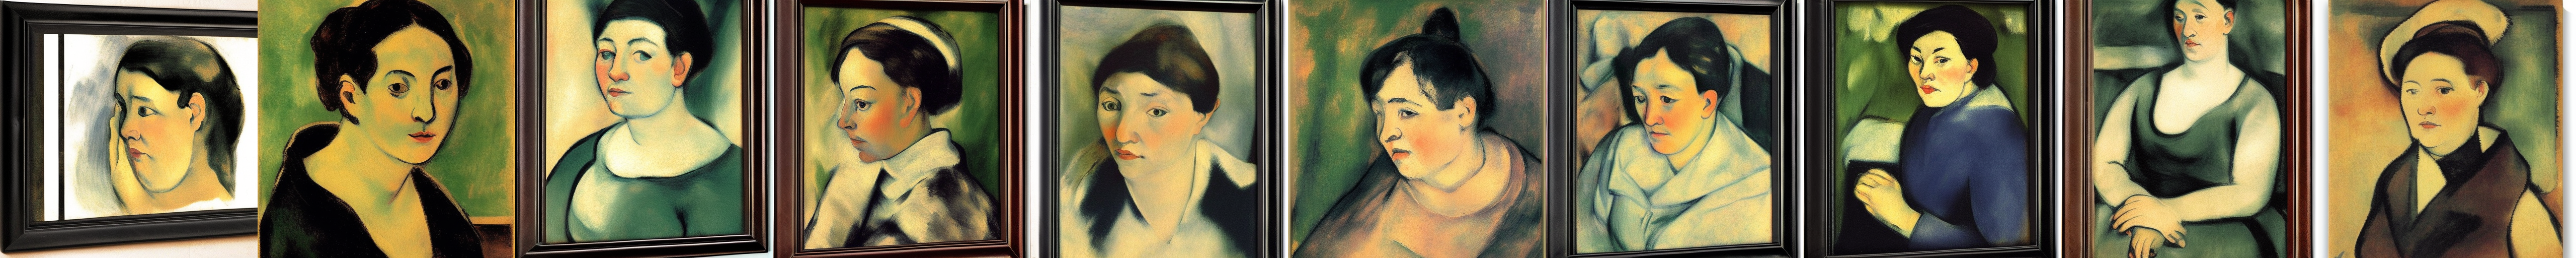

In [18]:
# Plot image results
images = decode_latent(particles, pipe.vae)
images = output_to_img(images)
images = (images * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

max_cols = 10
numparticles = len(pil_images)
ncols = max_cols if numparticles > max_cols else numparticles
nrows = int(np.ceil(numparticles / ncols))
grid = image_grid(pil_images,nrows,ncols)
grid

In [ ]:
seed=0
generator = torch.Generator(device).manual_seed(seed)
torch.manual_seed(seed)
# For each style, create 500 images of "tree, {style}"
# Store all 21 latents as a torch
styles =  pd.read_csv("data/styles/styles.csv",header=None)
for style in styles[0]:
    # prompt = f"{label} on a white plate"
    prompt = f"tree, {style}"
    filename = "tree_" + style.replace(" ", "_")
    dst_path = os.path.join("data","styles", "latents", filename)
    os.makedirs(dst_path, exist_ok=True)
    print(style)
    for i in range(1):
        print(f"{filename}_{i}.png")
        latents = denoise([], 0, config, return_all_samples=True, generator=generator)
        latents = torch.cat(latents)
        torch.save(latents, os.path.join(dst_path , f"{filename}_{i}.pt"))

In [ ]:
# Visualise first n generated images of artist
n = 20
latents = []
for i in range(n):
    latent = torch.load(f'data/styles/artists/Leonid_Afremov/artist2_subject{i}_latent.pt')
    latents.append(latent[-1])
latents=torch.stack(latents)
images = decode_latent(latents, pipe.vae)
images = output_to_img(images)
images = (images * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

max_cols = 10
numparticles = len(pil_images)
ncols = max_cols if numparticles > max_cols else numparticles
nrows = int(np.ceil(numparticles / ncols))
grid = image_grid(pil_images,nrows,ncols)
grid.save('disney_samples.pdf')
grid

In [34]:
[style.replace(" ", "_") for style in styles[0]]

['realism', 'cubism', 'impressionism', 'abstract_expressionism', 'photo']

In [13]:
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style, VGG, VGG_dropout, VGG_noise
from src.datasets import StyleDataset, ArtistDataset
from src.train import train

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from collections import deque
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob
# Dataset
# dataset = StyleDataset()
dataset = ArtistDataset(return_scores=False)
train_sz = int(0.7 * len(dataset))
val_sz = int(0.1 * len(dataset))
test_sz = len(dataset) - train_sz - val_sz
train_set, val_set, test_set = random_split(dataset, [train_sz,val_sz,test_sz])

# Dataloader
batch_size = 32
train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
val_dl = DataLoader(val_set, batch_size=val_sz)
test_dl = DataLoader(test_set, batch_size=test_sz)

In [ ]:
from torch import optim

model = VGG()
device="cuda"
model.to(device)

criterion = nn.NLLLoss()
lr = 1e-3
epochs = 1
opt = optim.Adam(model.parameters(), lr=lr)
batches = len(train_dl)

seed=0
generator = torch.Generator(device).manual_seed(seed)
torch.manual_seed(seed)
train_losses, val_losses, train_accs, val_accs = train(model, criterion, epochs, opt, train_dl, val_dl)

In [25]:
model = VGG_noise(num_outputs=20, logsoftmax=True)
model.to(device)
model.load_state_dict(torch.load('data/model_chk/old_remove_later/artist_noise_classifier_epoch2000_final.pt'))
# f = np.load(path)
# train_losses, val_losses, train_accs, val_accs = f['train_losses'][:], f['val_losses'][:], f['train_accs'][:], f['val_accs'][:]
# f.close()

<All keys matched successfully>

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# fig.suptitle('Training Curves', fontsize=20)

ax1.plot(train_losses)
ax1.plot(val_losses)
ax1.set_title('Loss', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_yscale('log')
ax1.legend(['train', 'validation'], loc = 'upper right', fontsize=12)

ax2.plot(np.multiply(train_accs,100))
ax2.plot(np.multiply(val_accs,100))
ax2.set_title('Accuracy', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=14)
# plt.yscale('log')
ax2.legend(['train', 'validation'], loc = 'lower right', fontsize=12)

plt.show()

In [27]:
from sklearn.metrics import classification_report, precision_score, recall_score
# Test model on testing dataset
classes = dataset.styles
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0
confusion_matrix = np.zeros((len(classes), len(classes)))

noise_cond = True
confidence = [] # confidence for each noise level
with torch.no_grad():
    for lvl in range(dataset.noise_levels):
        for i, (images, labels) in enumerate(test_dl):
            model_input = images[:,lvl,...]
            if noise_cond:
                lvl_input = torch.ones(n, device=device) / dataset.noise_levels
                pred = model(model_input, lvl_input)
            else:
                predictions = model(model_input)
            conf, predicted = torch.max(predictions.data, 1)
            confidence.append(torch.exp(conf))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            # Analyse errors for per-class accuracy and confusion matrix
            for true_label, pred_label in zip(labels, predicted):
                if true_label == pred_label:
                    correct_pred[classes[true_label]] += 1
                total_pred[classes[true_label]] += 1
                confusion_matrix[true_label, pred_label] += 1

confidence = torch.stack(confidence)
# Calculate per-class accuracy
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

print('----------------------------------------')
print('Network Accuracy: {:.2f} %'.format(100 * correct / total))
print('----------------------------------------')
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy()))

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 400 but got size 1 for tensor number 1 in the list.

In [ ]:

# Plot recall as bar chart
bar_labels = classes
recalls = np.multiply(recall_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average=None), 100)
width = 0.8
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(bar_labels, recalls, width, color=['silver', 'steelblue', 'skyblue', 'darkorange'])
for i in range(len(bars)):
    ax.annotate('{:.2f}%'.format(recalls[i]), xy=(bar_labels[i],recalls[i]/2), ha='center', va='bottom', fontsize='15')
ax.set_ylabel('Class Recall (%)', fontsize='15')
ax.set_title('Model Recall\nWeighted average = {:.3f}'.format(np.multiply(recall_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average='weighted'), 100)), fontsize='15')
ax.set_xticklabels(bar_labels, fontsize='15')
plt.show()

# Plot precision as bar chart
precs = np.multiply(precision_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average=None), 100)
width = 0.8
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(bar_labels, precs, width, color=['silver', 'steelblue', 'skyblue', 'darkorange'])
for i in range(len(bars)):
    ax.annotate('{:.2f}%'.format(precs[i]), xy=(bar_labels[i],precs[i]/2), ha='center', va='bottom', fontsize='15')
ax.set_ylabel('Class Precision (%)', fontsize='15')
ax.set_title('Model Precision\nWeighted average = {:.3f}'.format(np.multiply(precision_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average='weighted'), 100)), fontsize='15')
ax.set_xticklabels(bar_labels, fontsize='15')
plt.show()

In [ ]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(8,5))

class_names = list(classes)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, cmap='summer', annot=True, annot_kws={"size":15}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.title('Confusion matrix', fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

In [ ]:
from torchvision.transforms.functional import to_pil_image
import torchvision
from PIL import Image, ImageDraw, ImageFont
# Display example test images with labels, predictions and confidence
# grid_img = to_pil_image(torchvision.utils.make_grid(images[:n], nrow=numrows))
noise_lvl = 10
imgs = decode_latent(images[:4,noise_lvl,...], pipe.vae)
imgs = output_to_img(imgs)
imgs = (imgs * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in imgs]

max_cols = 4
numparticles = len(pil_images)
ncols = max_cols if numparticles > max_cols else numparticles
nrows = int(np.ceil(numparticles / ncols))
grid_img = image_grid(pil_images,nrows,ncols)
width, height = grid_img.size
draw = ImageDraw.Draw(grid_img, 'RGBA')

# Size of rectangles behind text
x_border = 180
y_border = 50
font = ImageFont.truetype('data/pixel.ttf', 20)

i = 0
for row in range(1,nrows+1):
  for col in range(1,ncols+1):
  
    x = width*col/ncols - width/ncols * 0.96
    y = height*row/nrows - height/nrows

    # Rectangle behind text for readabilty
    draw.rectangle((x-3, y-1, x + x_border, y + y_border), fill=(0,0,0,180))

    # Display labels, predictions, confidence
    pred_msg = 'Prediction: {}'.format(classes[predicted[i]])
    conf_msg = 'Confidence: {:.2f}'.format(confidence[noise_lvl,i])
    lab_msg = 'Label: {}'.format(classes[labels[i]])
    draw.text((x,y), lab_msg, fill='white', font=font)
    draw.text((x,y+15), pred_msg, fill='white', font=font)
    draw.text((x,y+30), conf_msg, fill='white', font=font)

    i+=1

plt.figure(figsize=(20,20))
plt.imshow(grid_img)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Plot confidence of predictions at different noise levels
import matplotlib.patches as mpatches
s = dataset.styles
c = {s[0]: 'b', s[1]: 'g', s[2]: 'r', s[3]: 'c', s[4]: 'm'}
for i in range(20):
    plt.plot(confidence[:,i].cpu().numpy(), color=c[classes[labels[i]]])
handles = []
for style, colour in c.items():
    handles.append(mpatches.Patch(color=colour, label=style))
plt.legend(handles=handles)
plt.xlabel("Noise levels")
plt.ylabel("Confidence")